# Network Construction

In [10]:
import networkx as nx # make sure you installed networkx
import pandas as pd
import numpy as np

# Graph including only positive corsi influences
# Read in data
df = pd.read_csv("../../data/defense/defensemen_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'corsi_influence_on_player2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','corsi_influence_on_player1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)


# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
players_df = pd.read_csv("../../data/defense/aggregate_defensemen.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# on ice corsi
player_onIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_onIce_corsi = players_df.loc[[player]]["onIce_corsiPercentage"].values[0]
    player_onIce_corsis[player] = player_onIce_corsi

nx.set_node_attributes(G, player_onIce_corsis, "onIce_corsiPercentage")

# off ice corsi
player_offIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_offIce_corsi = players_df.loc[[player]]["offIce_corsiPercentage"].values[0]
    player_offIce_corsis[player] = player_offIce_corsi

nx.set_node_attributes(G, player_offIce_corsis, "offIce_corsiPercentage")

# on/off ice corsi diff
player_corsi_diffs = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_corsi_diff = players_df.loc[[player]]["on_off_corsi_diff"].values[0]
    player_corsi_diffs[player] = player_corsi_diff

nx.set_node_attributes(G, player_corsi_diffs, "on_off_corsi_diff")

# on ice goals for per 60
player_gf_per60s = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_gf_per60 = players_df.loc[[player]]["OnIce_F_goals_per60"].values[0]
    player_gf_per60s[player] = player_gf_per60

nx.set_node_attributes(G, player_gf_per60s, "onIce_F_goals_per60")

# d zone giveaways per 60
players_dz_giveaways = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_dz_giveaways = players_df.loc[[player]]["I_F_dZoneGiveaways_per60"].values[0]
    players_dz_giveaways[player] = player_dz_giveaways

nx.set_node_attributes(G, players_dz_giveaways, "I_F_dZoneGiveaways_per60")

# average icetime
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_TOI"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_TOI")




# Basic Statistics


In [11]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)


Number of nodes:  519
Number of edges:  2241


In [12]:
# Number of connected components
is_strongly_connected = nx.is_strongly_connected(G)
print("Is graph strongly connected? ", is_strongly_connected)
num_strongly_connected_components = nx.number_strongly_connected_components(G)
print("Number of strongly connected components: ", num_strongly_connected_components)

is_weakly_connected = nx.is_weakly_connected(G)
print("Is graph weakly connected? ", is_weakly_connected)
num_weakly_connected_components = nx.number_weakly_connected_components(G)
print("Number of weakly connected components: ", num_weakly_connected_components)


Is graph strongly connected?  False
Number of strongly connected components:  72
Is graph weakly connected?  False
Number of weakly connected components:  6


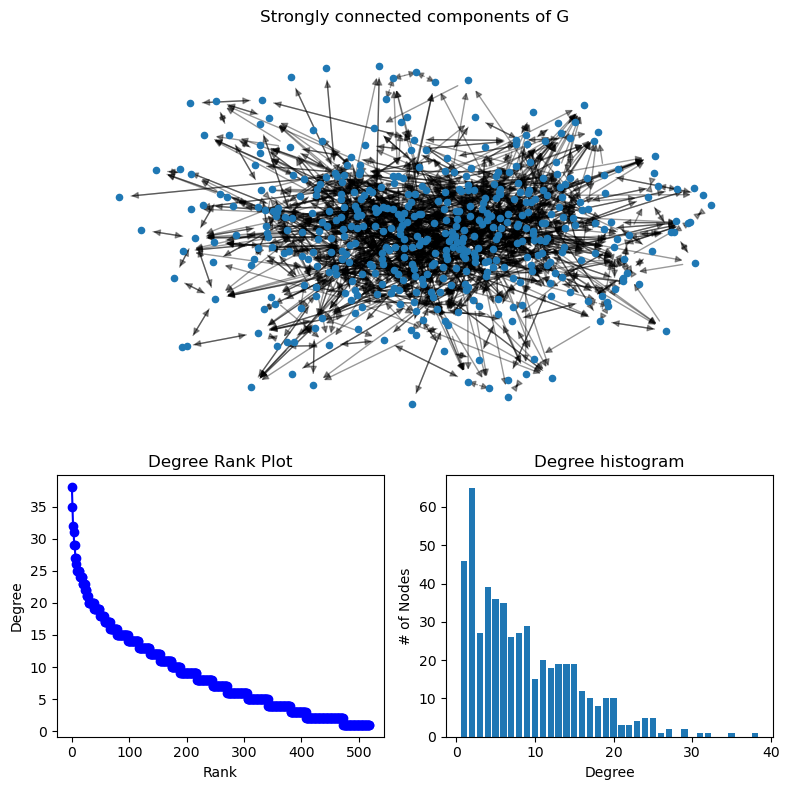

In [13]:
# Degree distribution
import matplotlib.pyplot as plt
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.strongly_connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


# Community Analysis

In [14]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
greedy_communities = nxc.greedy_modularity_communities(G, weight='weight')
print(len(greedy_communities))

# add community info to node attributes
i = 0
greedy_communities_dict = dict.fromkeys(G.nodes)
for community in greedy_communities:
    for player in community:
        greedy_communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, greedy_communities_dict, "greedy_community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'defense-positive.gexf')


24


In [15]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv("../../data/defense/aggregate_defensemen.csv", index_col='playerId', header=0)

# Remove players with less than 10 games to clean up playerbase data a bit
players_df = players_df.drop(players_df[players_df.games_played < 10].index)



0.4906513230206397
0.032884988693816515


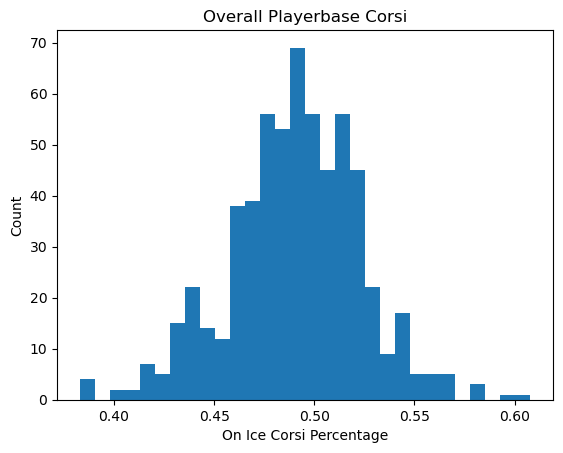

0.48921060181661075
0.02900446463000617


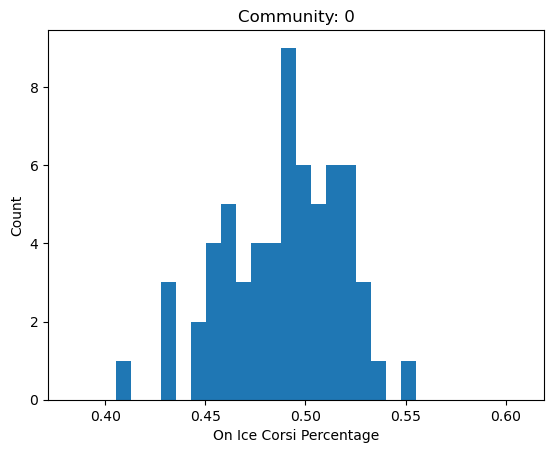

0.4958121434574887
0.025029746339846056


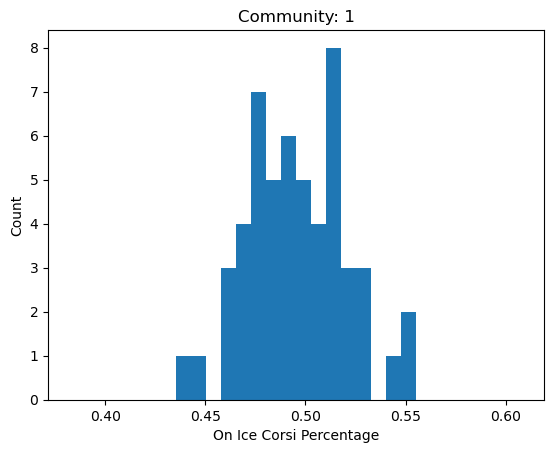

0.4901051599745067
0.023184706000788816


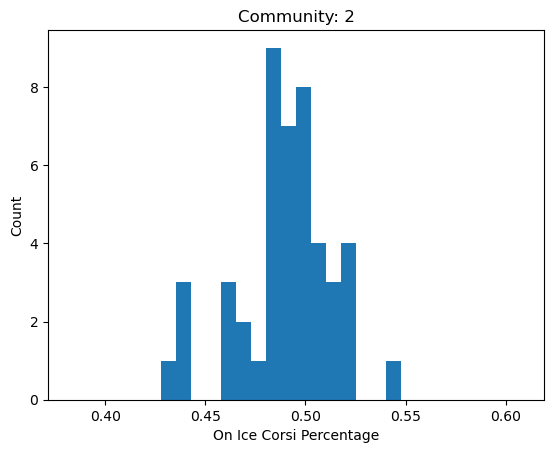

0.5063245627926758
0.03060730232199521


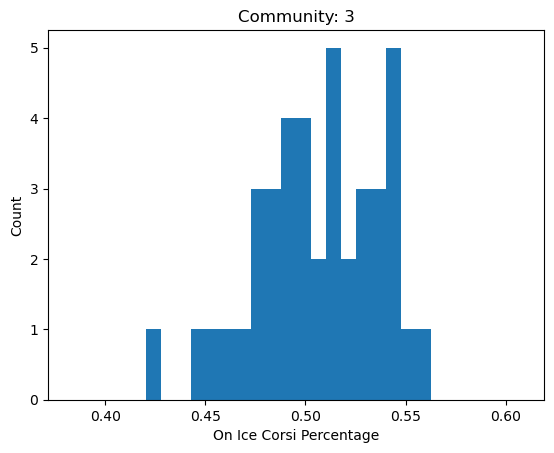

0.4857894661047386
0.025488807625923426


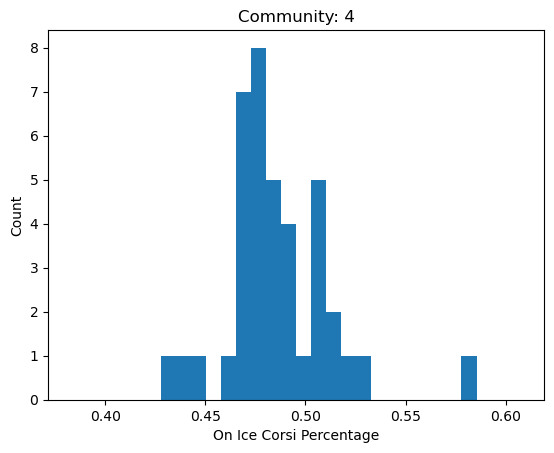

0.4913561377950514
0.029017797165290224


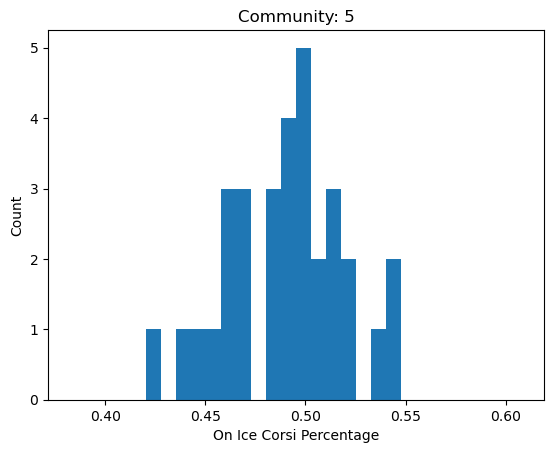

0.48880691662836545
0.032476289481712585


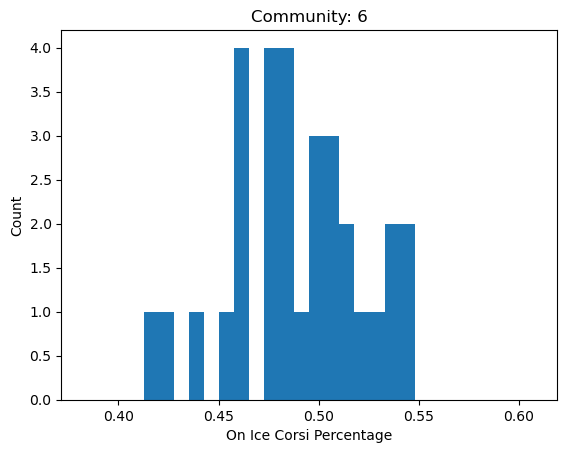

0.5009558750257159
0.017772970892352066


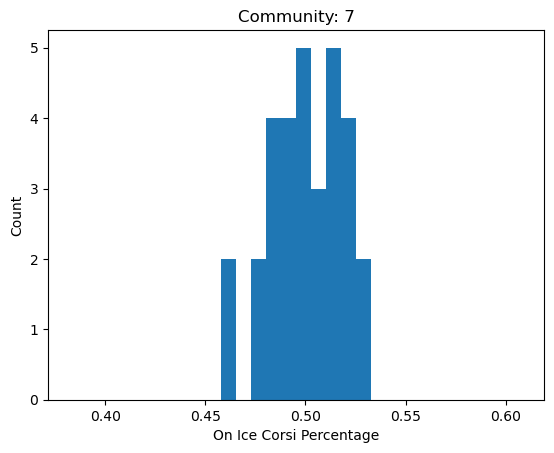

0.4963029058873303
0.028353348836401265


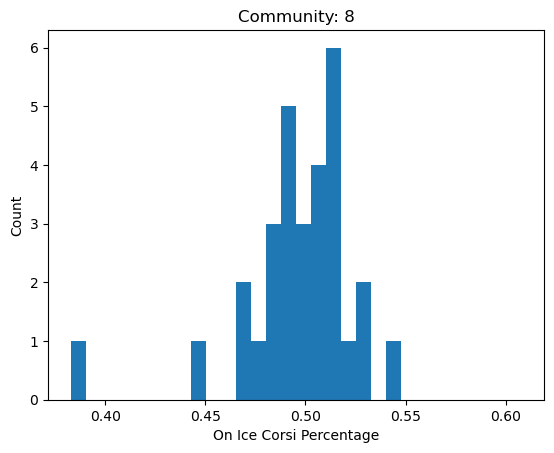

0.47865434273063434
0.024223621218690386


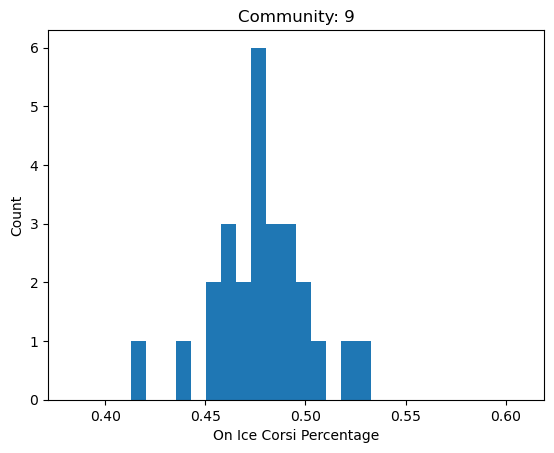

0.4980355098835526
0.03010376795669553


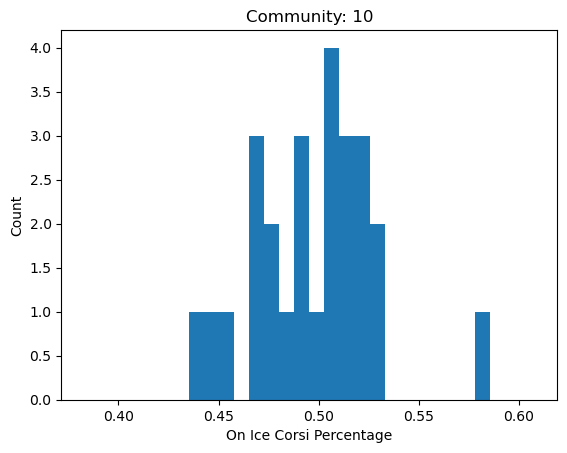

0.5089009101613589
0.028760934205214615


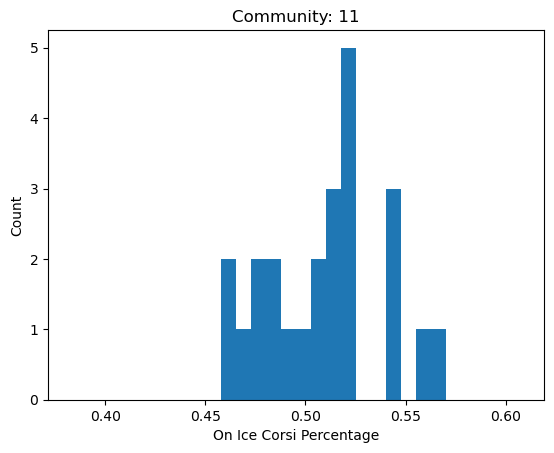

0.4942791677388964
0.030314632161199565


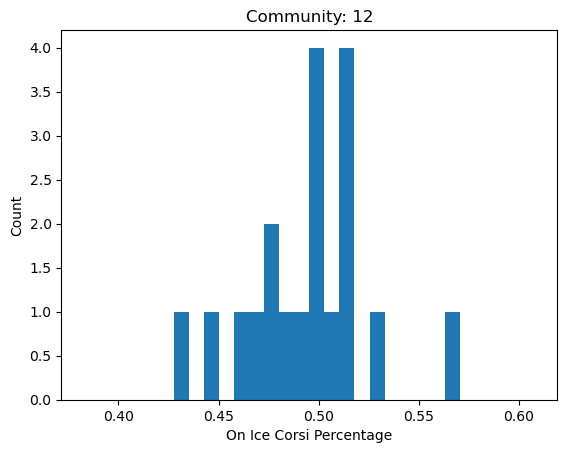

0.4848110285138486
0.02947727155723888


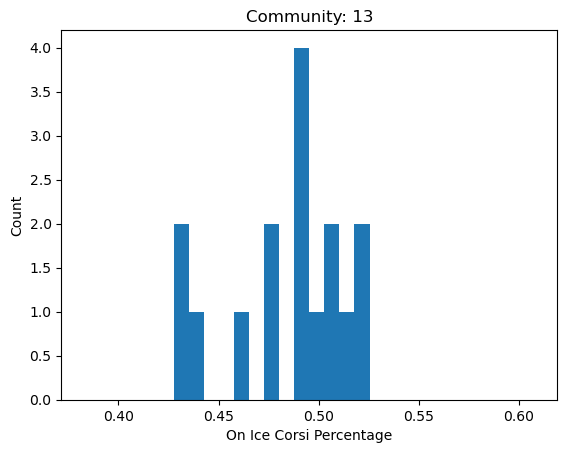

0.4879897311202331
0.017884349213206967


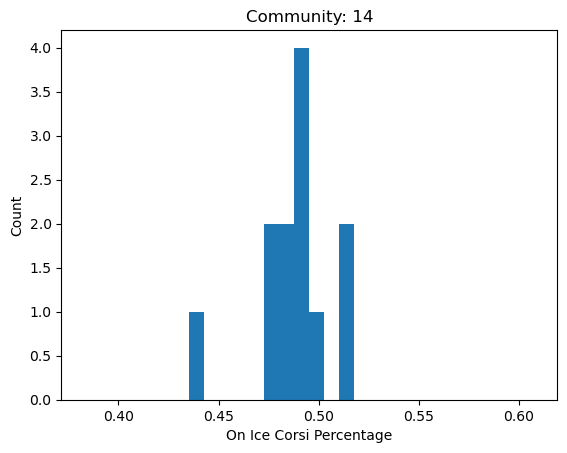

0.5064891416096653
0.021744574715028813


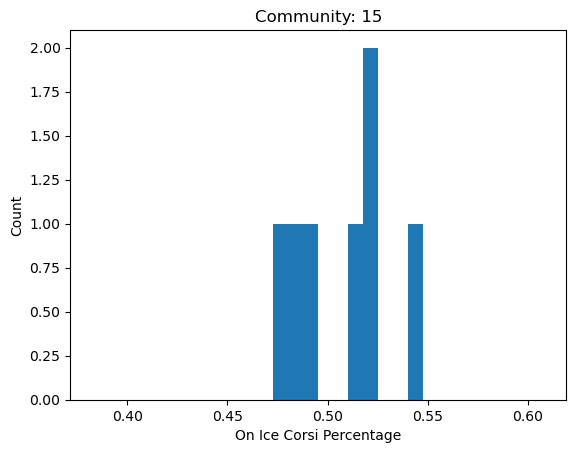

0.5517764500685812
0.02767833817551544


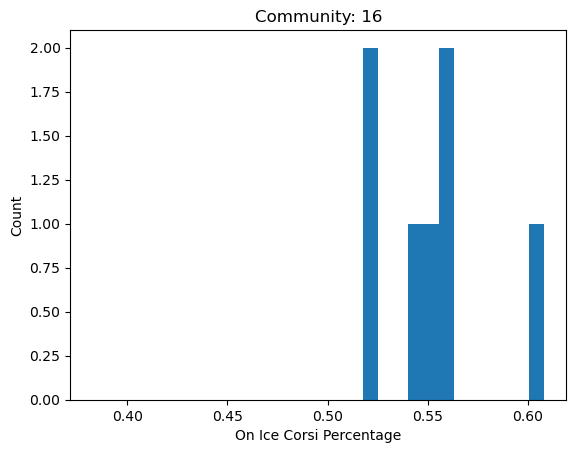

0.4830410435268668
0.006568410827710071


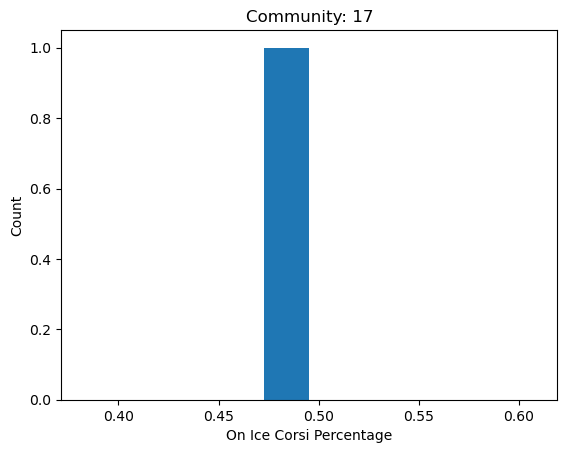

0.4731250024514262
0.01875021628525152


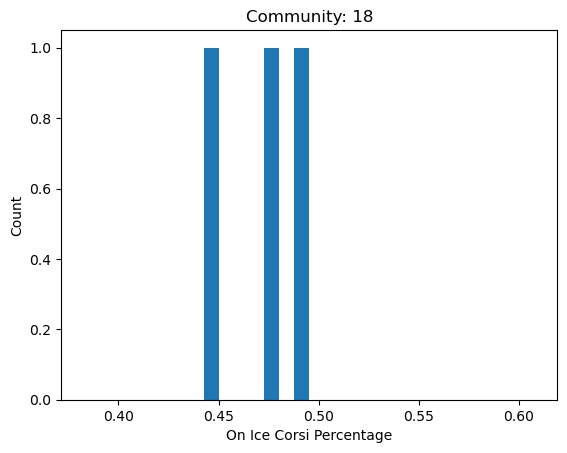

0.4500541978907824
5.419789078239812e-05


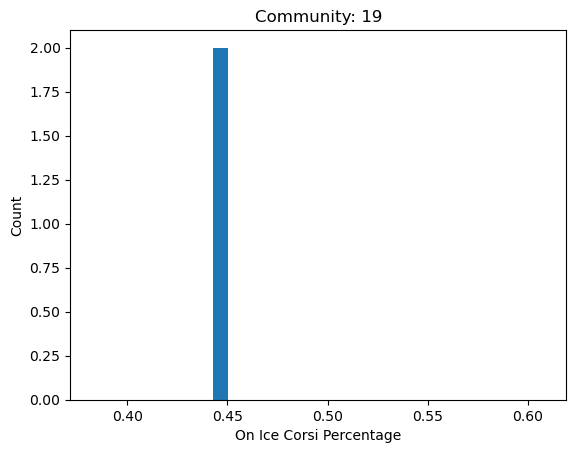

0.4837633563796354
0.01376335637963541


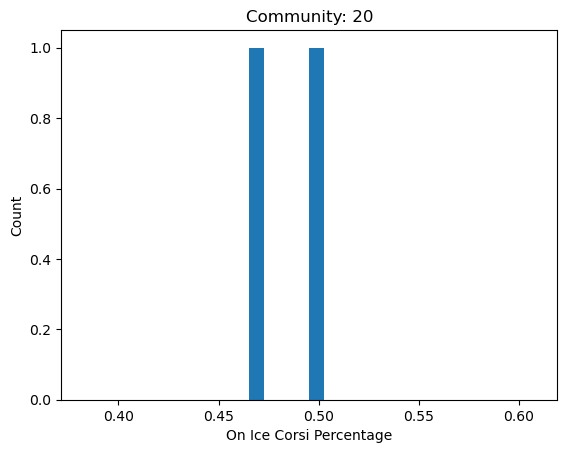

0.47347969653524846
0.01774429809590114


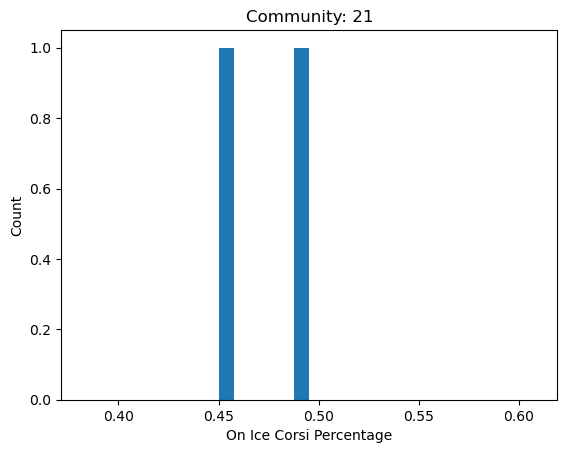

0.48922449060420037
0.028173011492096944


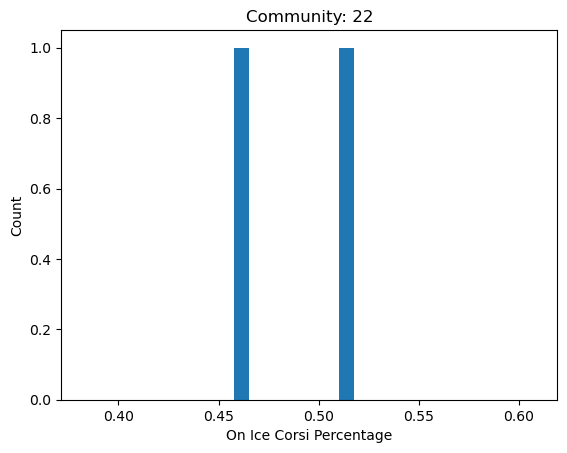

0.4234430416911333
0.0034430416911332973


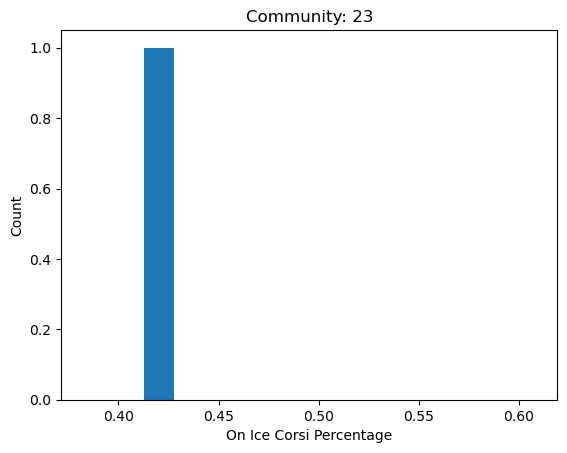

In [16]:
# Plot corsi distribution of entire playerbase
corsis = players_df["onIce_corsiPercentage"].values
print(corsis.mean())
print(corsis.std())
n, bins, patches = plt.hist(corsis, 30)
plt.xlabel("On Ice Corsi Percentage")
plt.ylabel("Count")
plt.title("Overall Playerbase Corsi")
plt.show()

# Plot corsi distribution of each community individually
graph_corsis = dict(G.nodes(data="onIce_corsiPercentage", default=1))
i = 0
for community in greedy_communities:
    players_corsi = []
    for player in community:
        players_corsi.append(graph_corsis[player])
    print(np.mean(players_corsi))
    print(np.std(players_corsi))
    plt.hist(players_corsi, bins)
    plt.xlabel("On Ice Corsi Percentage")
    plt.ylabel("Count")
    title = "Community: " + str(i)
    plt.title(title)
    plt.show()
    i += 1


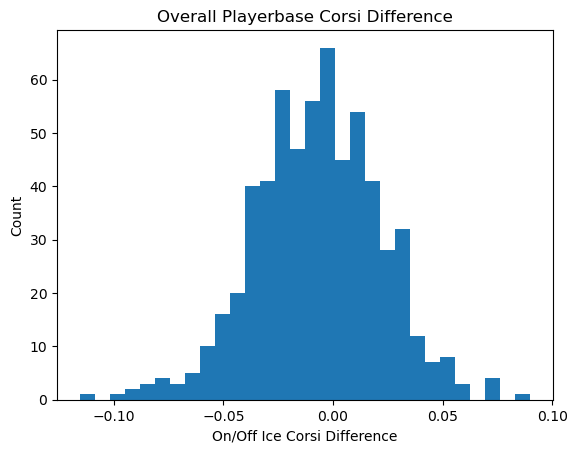

-0.005980761460027453
0.026597120097037474


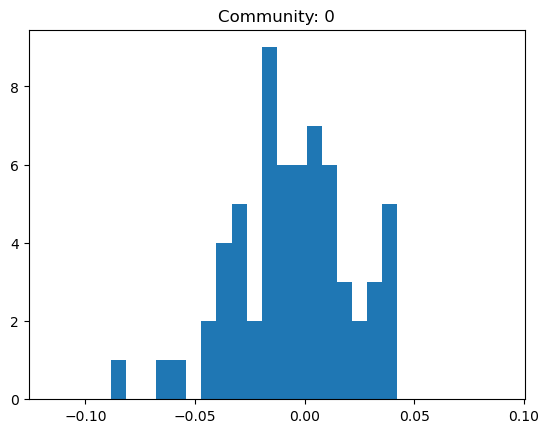

-0.003992706464624826
0.02238798639874207


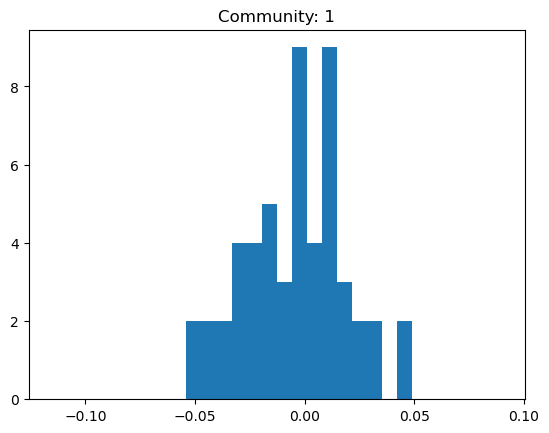

-0.006348429035815084
0.022621506072834426


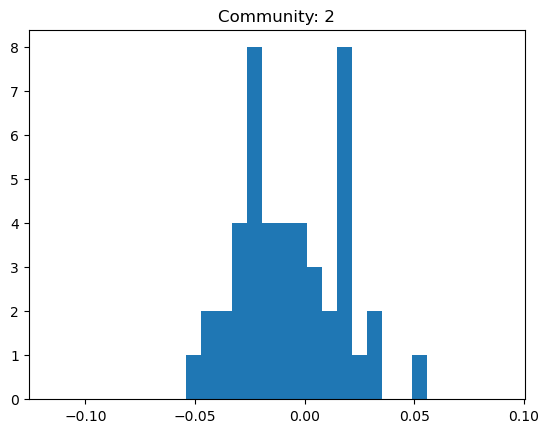

-0.00743892767253031
0.02838055911854456


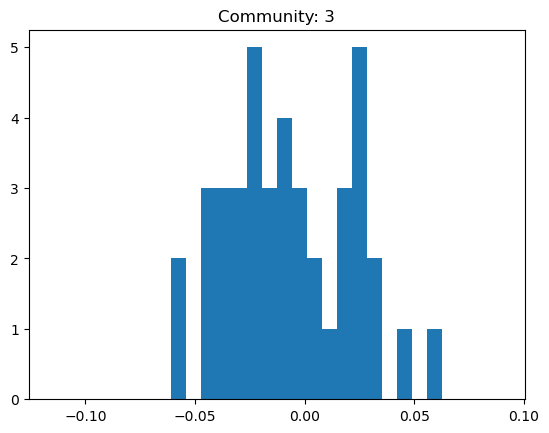

-0.00734432621608736
0.01936485688408818


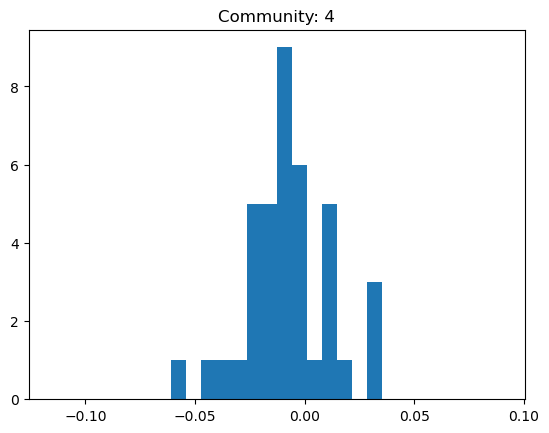

3.1884771277428136e-05
0.02427534189248242


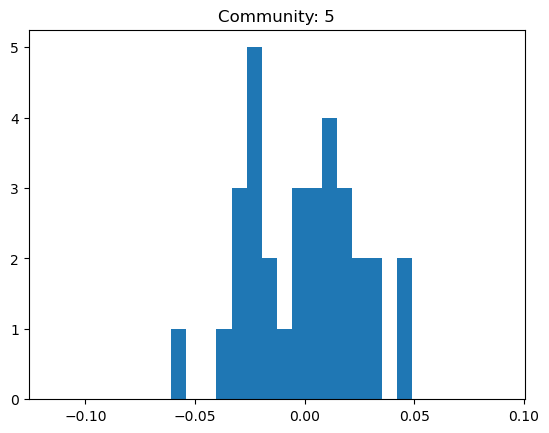

-0.005746489791324947
0.022625808737353106


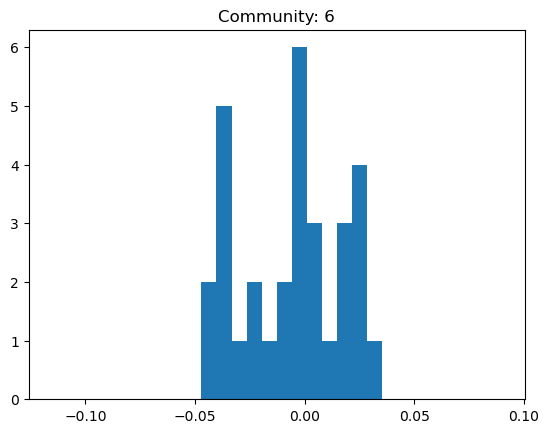

-0.002732231393885546
0.02336110718332132


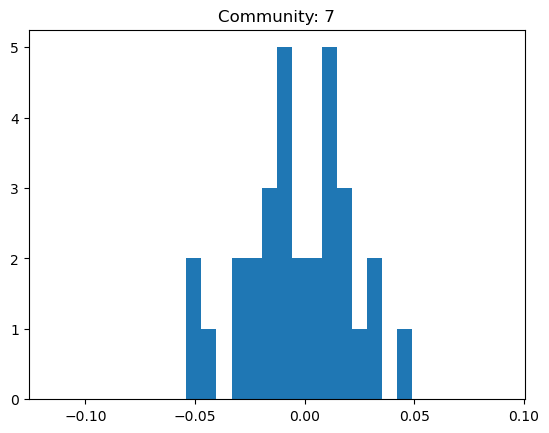

0.004151335333815904
0.025361662336772537


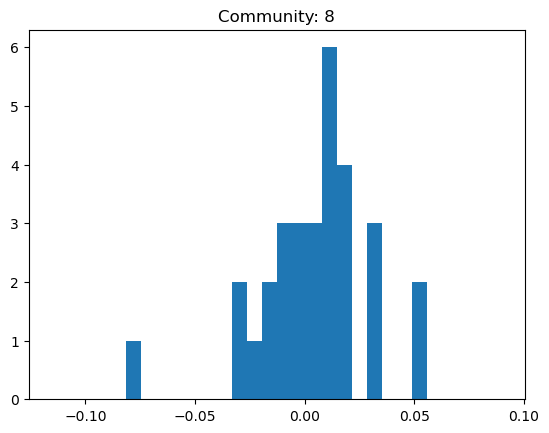

-0.0069053288060526635
0.024797860359591004


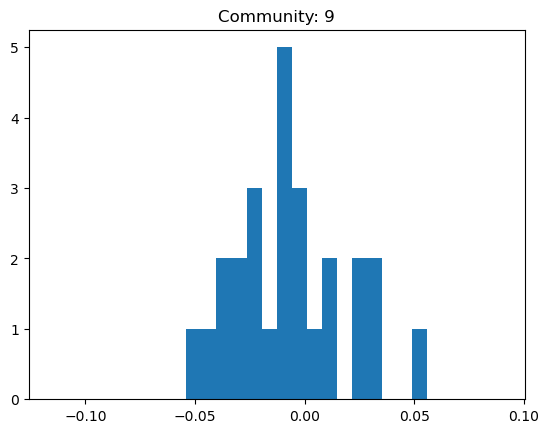

-0.003221630345929173
0.03400878062221217


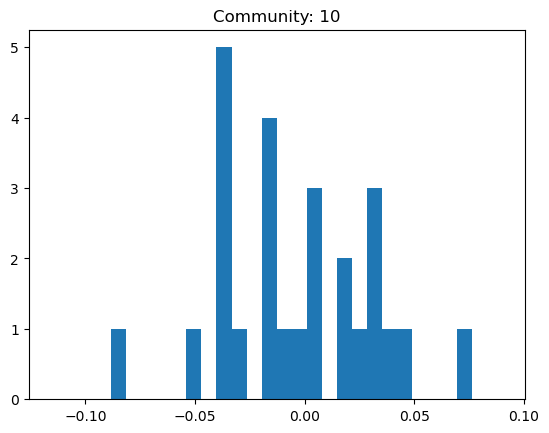

-0.01592167632991847
0.028377101967737735


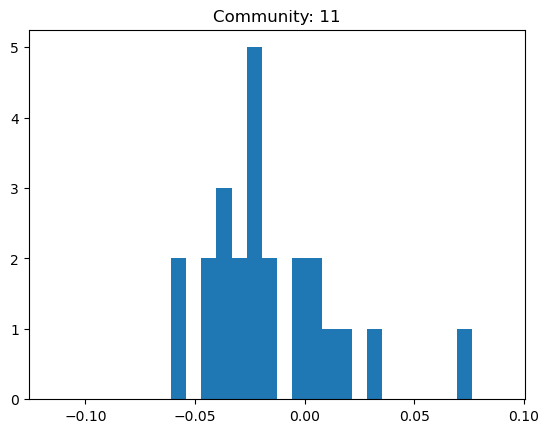

-0.004144954579080044
0.02920830866192438


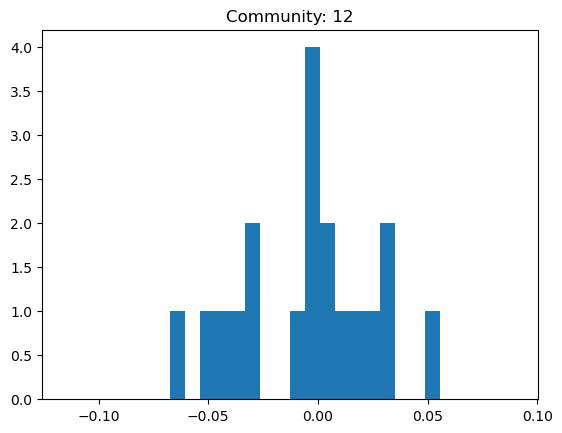

-0.002922758278710038
0.021602525678790327


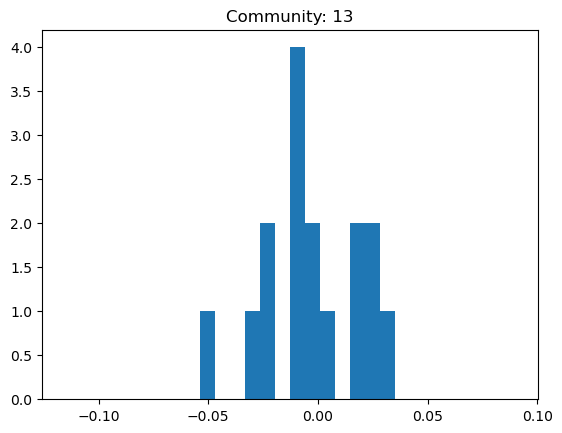

-0.003036543500166283
0.02961878216533507


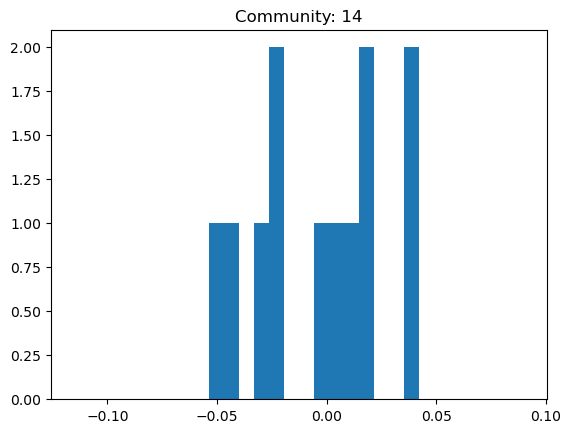

-0.007336747965724745
0.028182409691329874


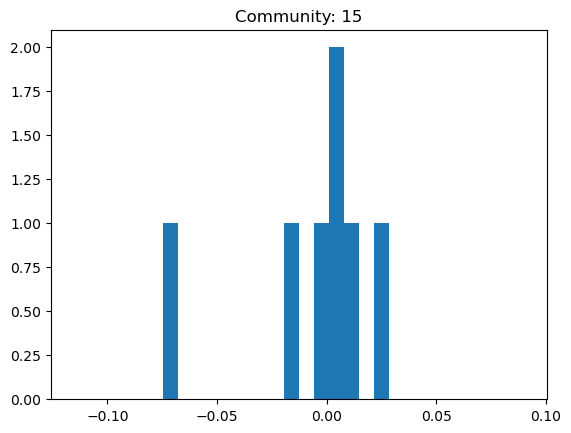

0.01779623768525237
0.022220890878983983


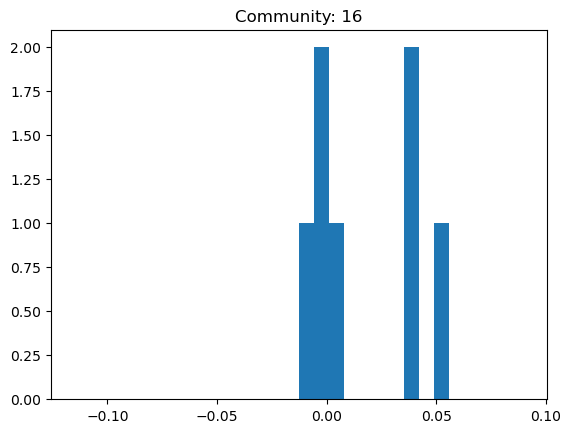

-0.011493741278939366
0.013467859372244474


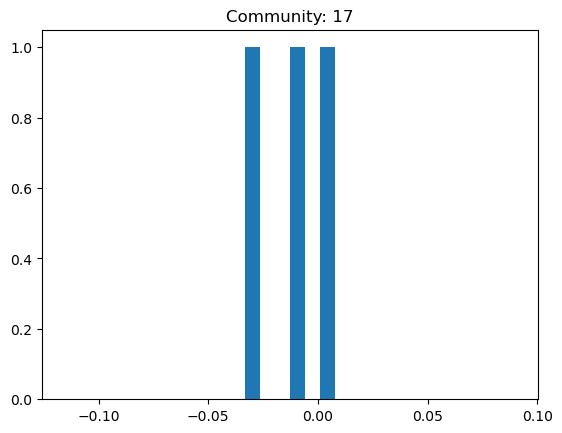

0.004994296760953966
0.017647722918866803


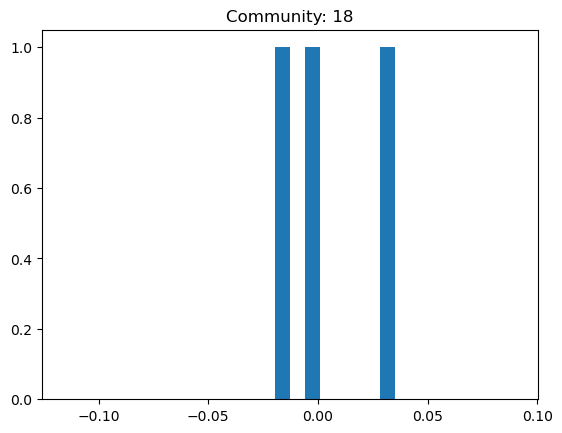

0.0204210472637798
0.0295789527362201


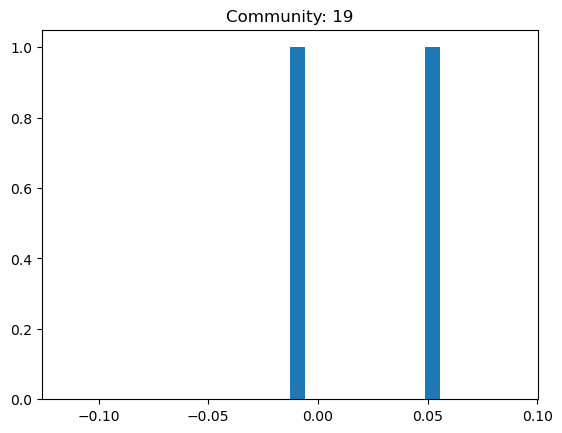

-0.0214286684391712
0.0014286684391712004


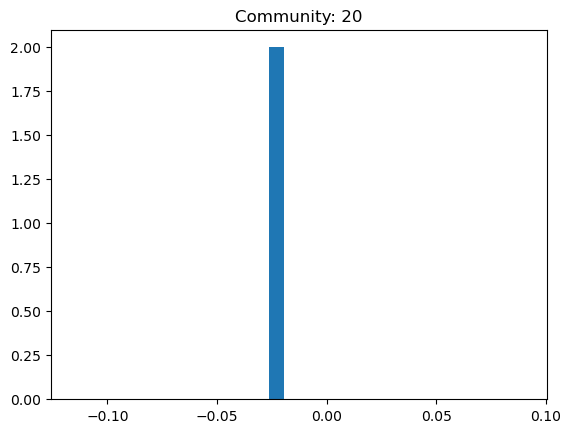

0.0013855957565069498
0.011171968788235849


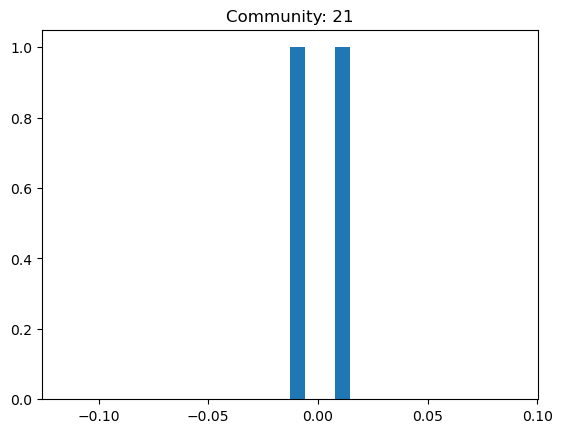

-0.015854565823754097
0.0571265077962467


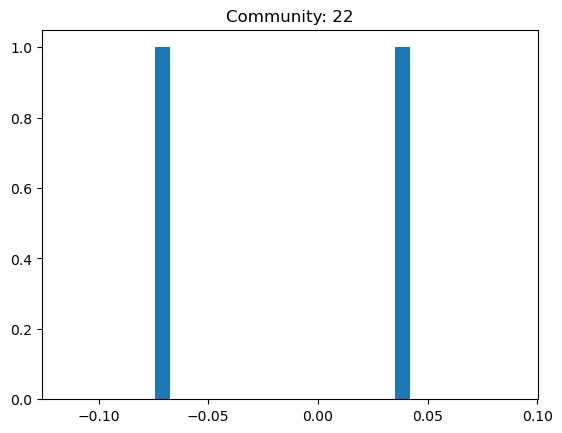

-0.03941916649769635
0.0005808335023036494


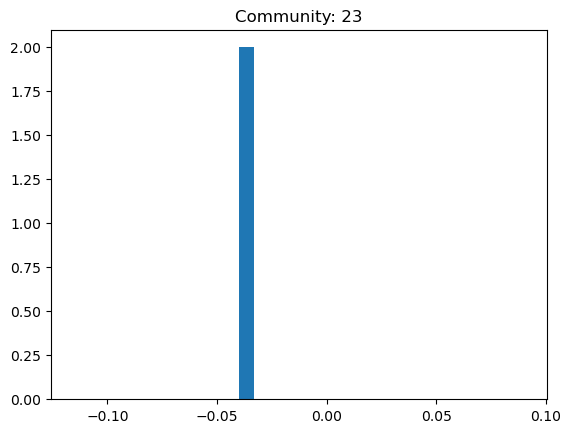

In [17]:
# Plot on/off corsi diff of entire playerbase
corsi_diffs = players_df["on_off_corsi_diff"].values
n , bins, patches = plt.hist(corsi_diffs, 30)
plt.xlabel("On/Off Ice Corsi Difference")
plt.ylabel("Count")
plt.title("Overall Playerbase Corsi Difference")
plt.show()

# Plot distribution of each community individually
graph_corsi_diffs = dict(G.nodes(data="on_off_corsi_diff", default=1))
i = 0
for community in greedy_communities:
    players_corsi = []
    for player in community:
        players_corsi.append(graph_corsi_diffs[player])
    print(np.mean(players_corsi))
    print(np.std(players_corsi))
    plt.hist(players_corsi, bins)
    title = "Community: " + str(i)
    plt.title(title)
    plt.show()
    i += 1


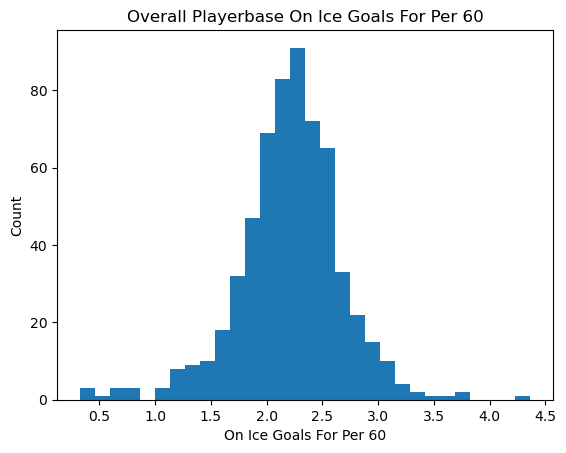

2.222101324147486
0.374905080097274


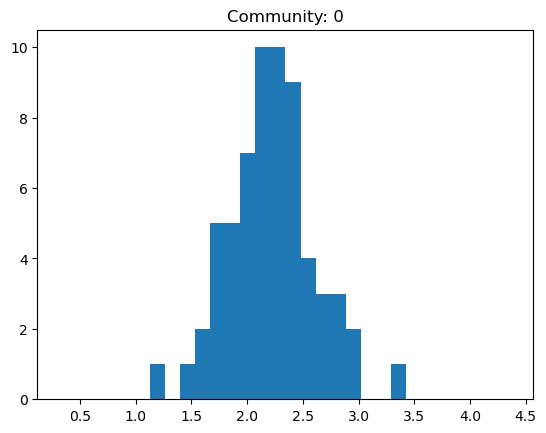

2.335047758483711
0.3665046190225299


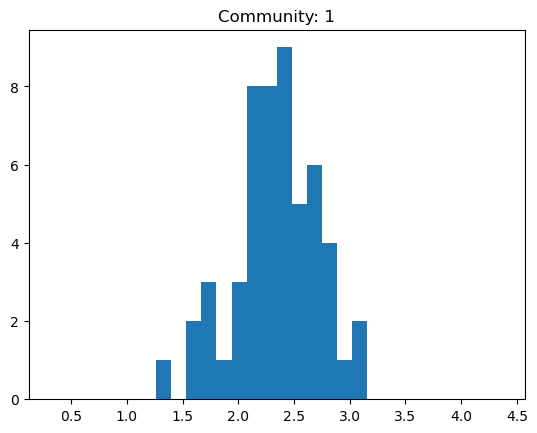

2.231545290568645
0.3017684175181711


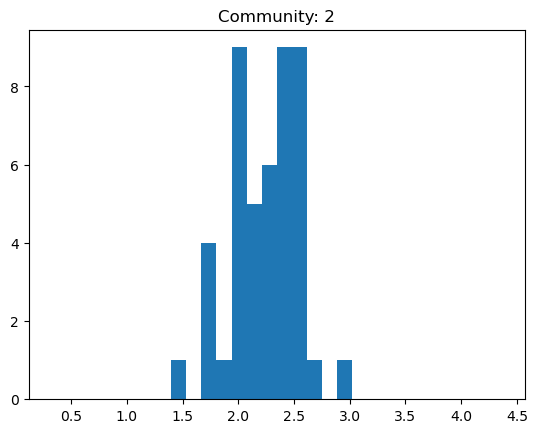

2.343950483970606
0.3541771460729427


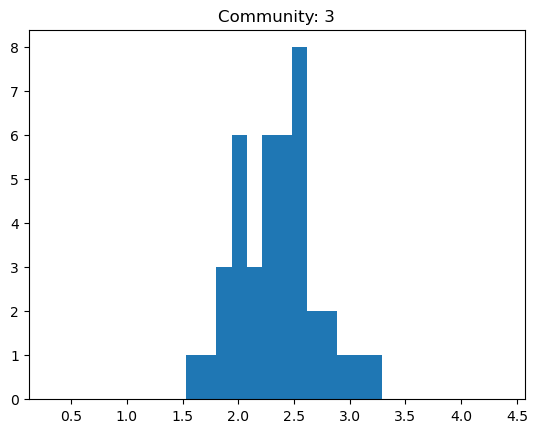

2.3133998300419085
0.36845599331668144


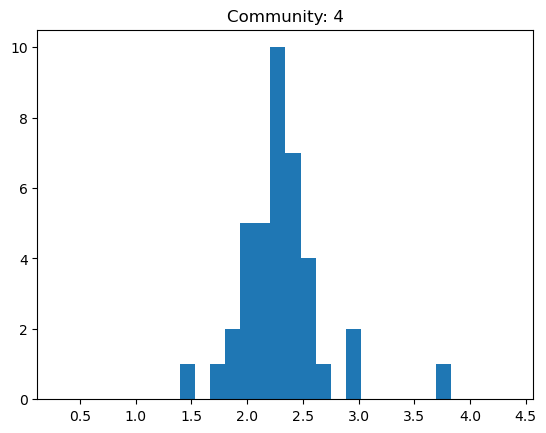

2.2320290200088153
0.29325385709197654


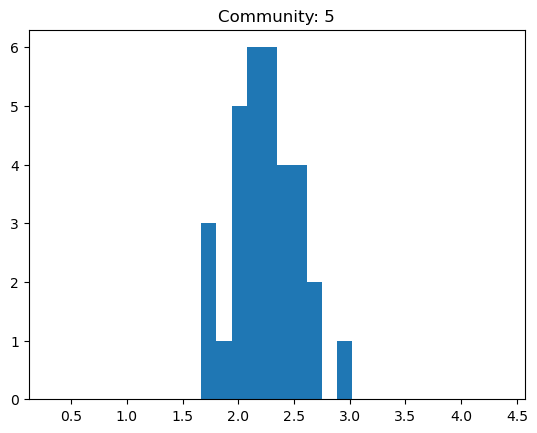

2.360837823479012
0.45686798683352775


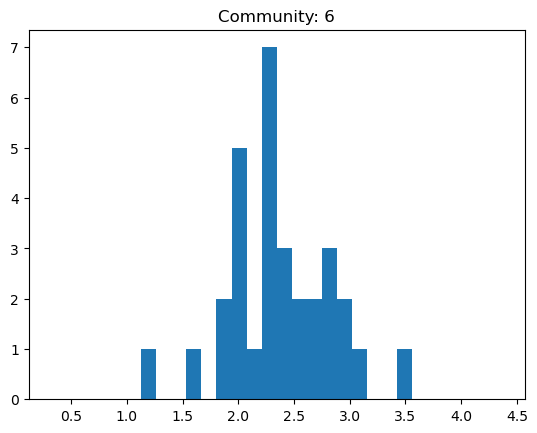

2.306217411934299
0.22952113384280626


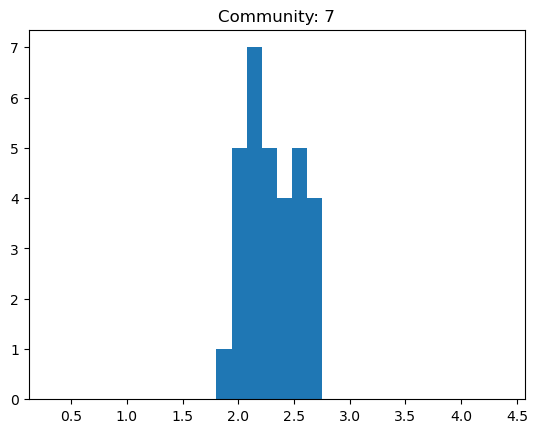

2.1947891200841676
0.32071563835877226


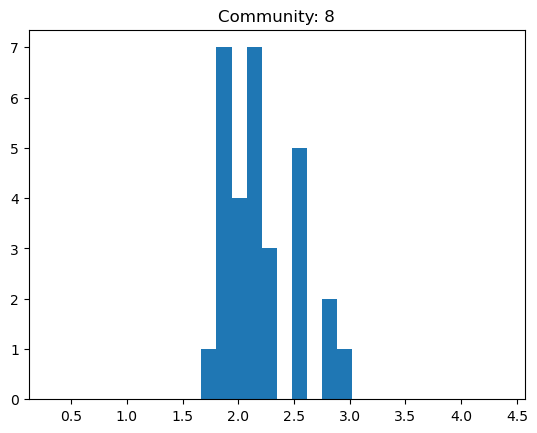

2.15832674578185
0.32444390250935295


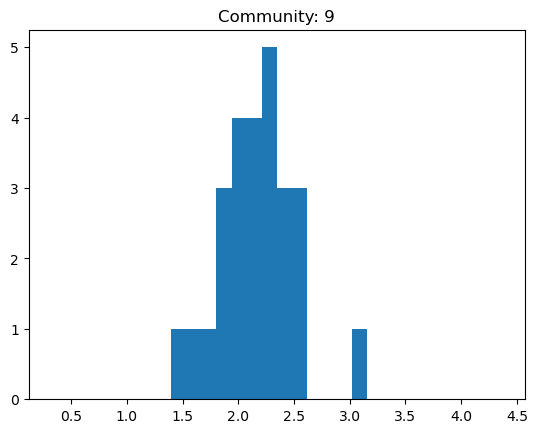

2.193276663187926
0.44173092659042307


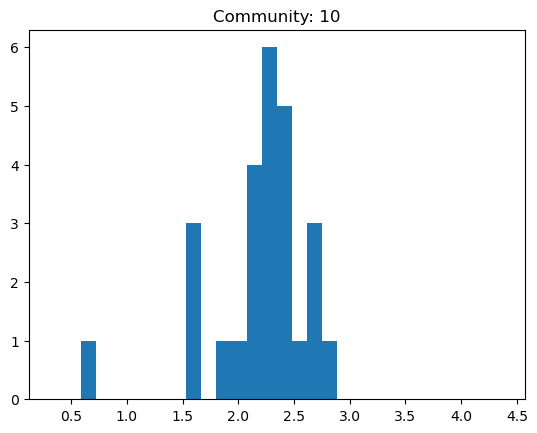

2.1196275730051366
0.2531585235932337


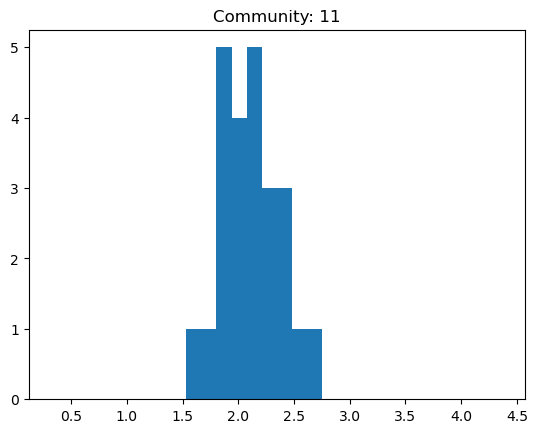

2.3133834372409994
0.3431890741058053


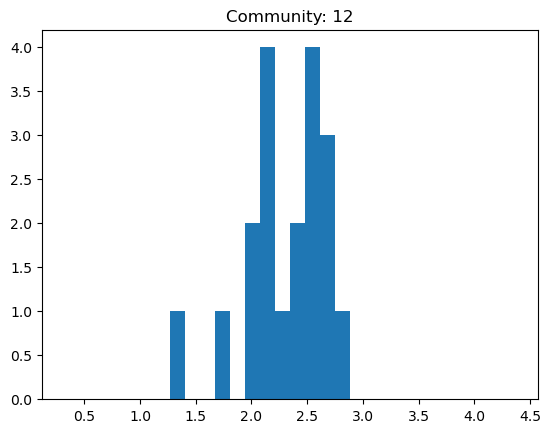

2.1087050756617036
0.33877632210559416


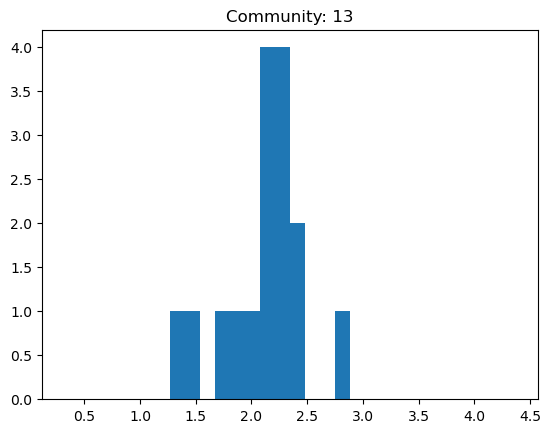

2.2107960768406545
0.40066161561667496


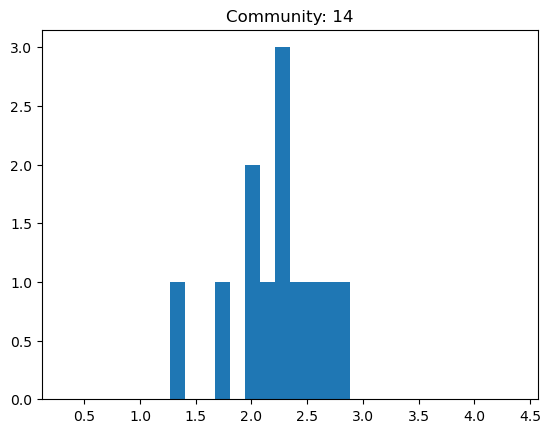

1.6791832079574416
0.29359476164475223


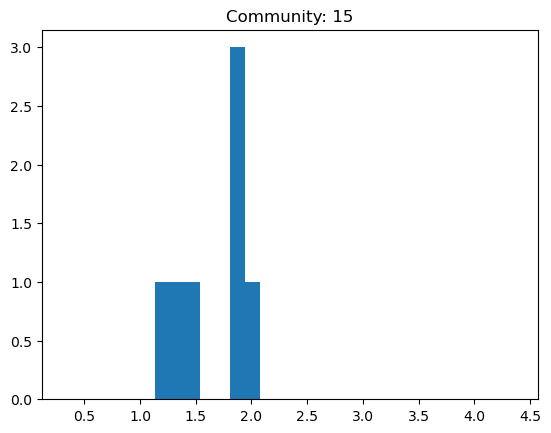

2.8867083702609477
0.3160730115994486


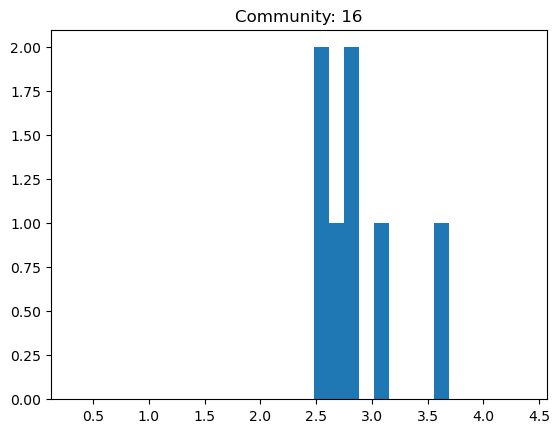

2.519493003919921
0.1172882936936667


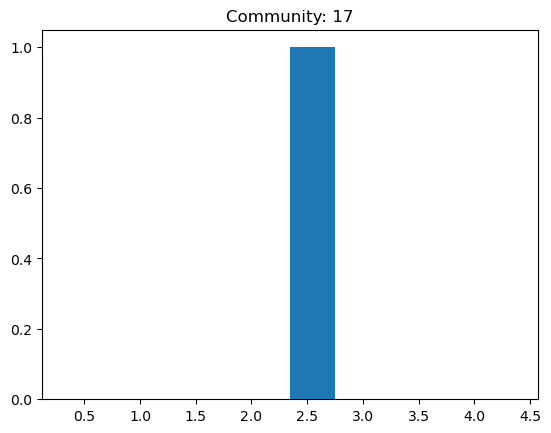

2.078335798379362
0.0824856173892289


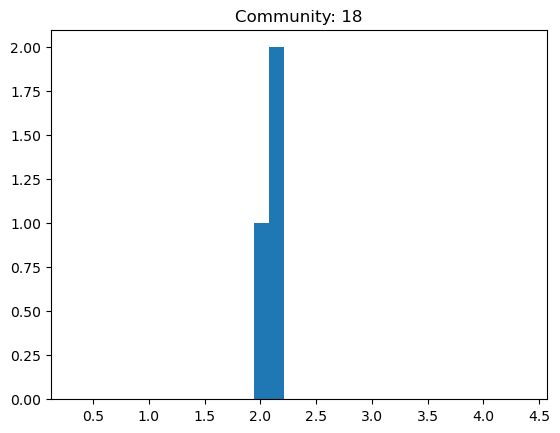

2.292806180674302
0.03880003694227807


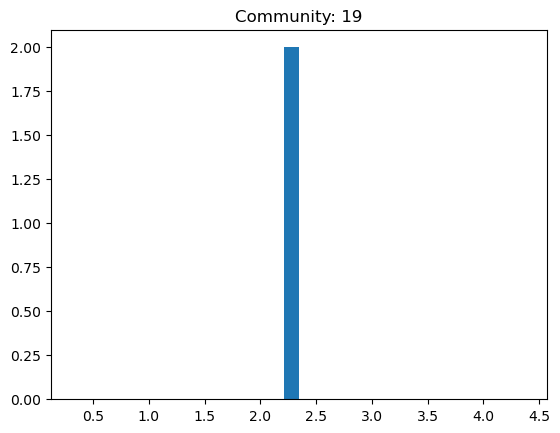

1.4437656945774877
0.0647195348379741


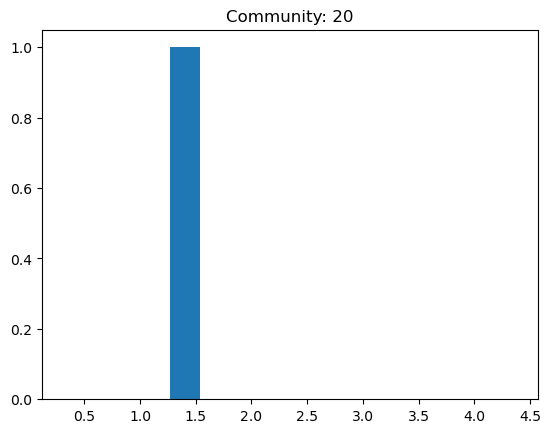

1.5701668014750836
0.009514164917978074


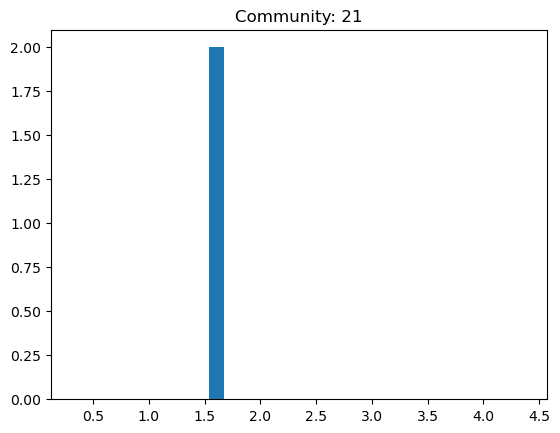

1.723938748064619
0.02371119235640562


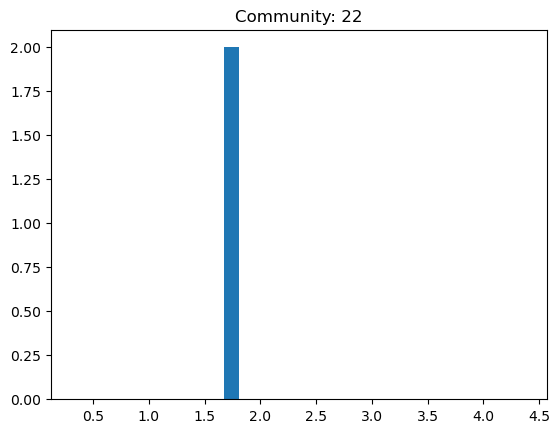

1.6675047051774614
0.504850565424085


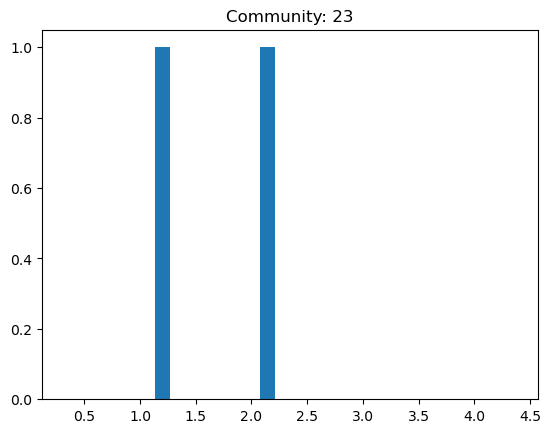

In [18]:
# Plot on ice goals for per 60 of entire playerbase
gp60s = players_df["OnIce_F_goals_per60"].values
n , bins, patches = plt.hist(gp60s, 30)
plt.xlabel("On Ice Goals For Per 60")
plt.ylabel("Count")
plt.title("Overall Playerbase On Ice Goals For Per 60")
plt.show()

# Plot distribution of each community individually
node_data = dict(G.nodes(data="onIce_F_goals_per60", default=1))
i = 0
for community in greedy_communities:
    community_player_stats = []
    for player in community:
        community_player_stats.append(node_data[player])
    plt.hist(community_player_stats, bins)
    print(np.mean(community_player_stats))
    print(np.std(community_player_stats))
    title = "Community: " + str(i)
    plt.title(title)
    plt.show()
    i += 1


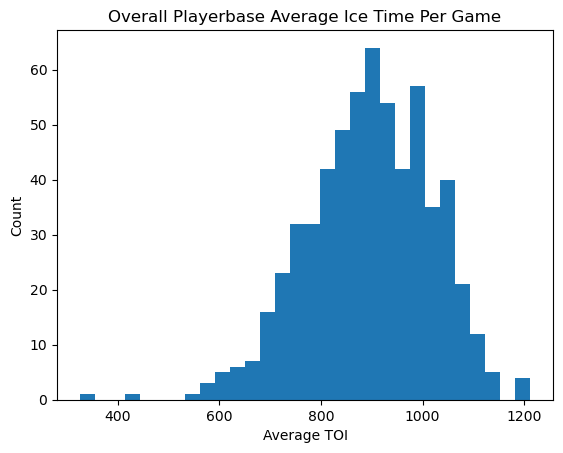

913.3515793140938
90.25403579960853


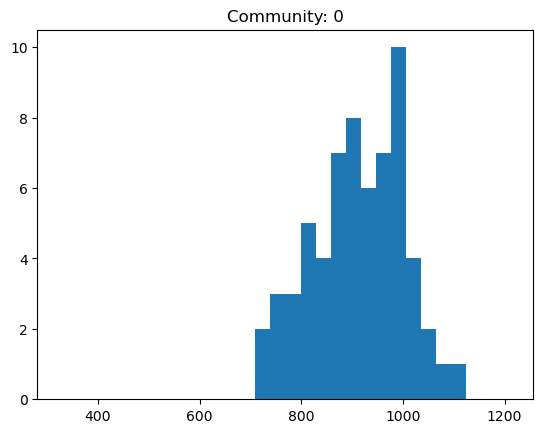

922.9665819672261
110.35891736232911


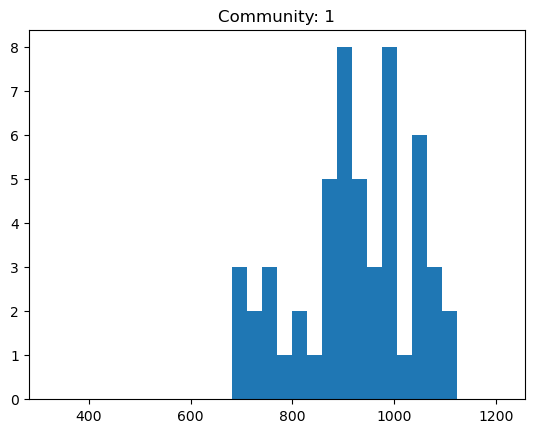

913.1400857975452
113.7478875525684


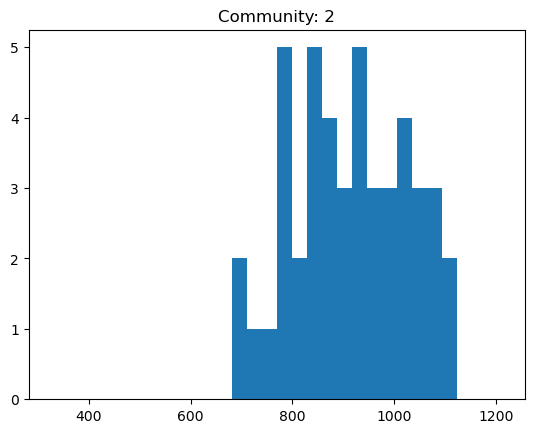

925.3057838651946
93.3303393679123


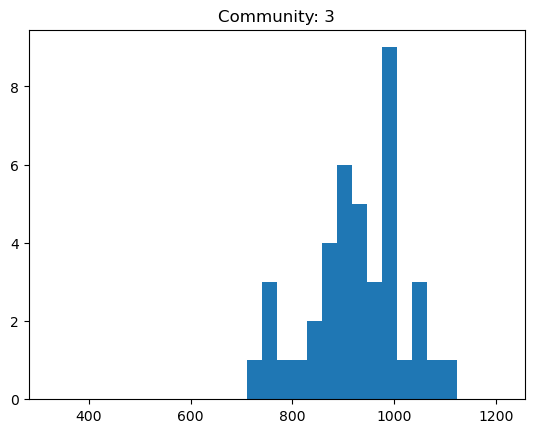

930.6368770280413
96.6772255146175


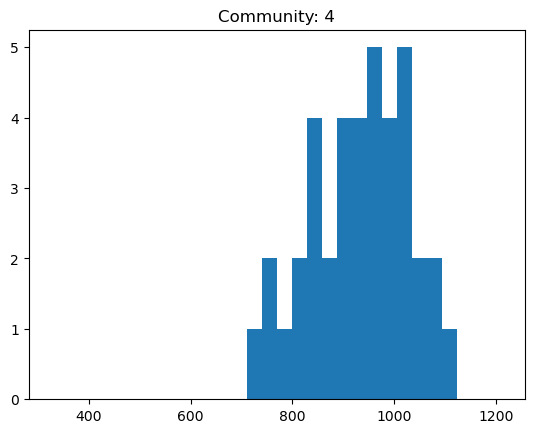

911.4055943616163
114.04102240523495


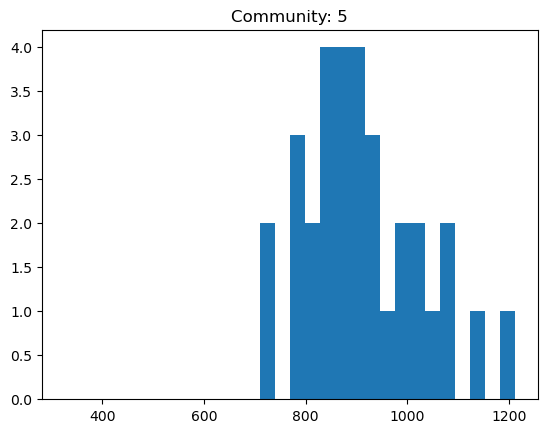

901.2333180366578
115.83370948651523


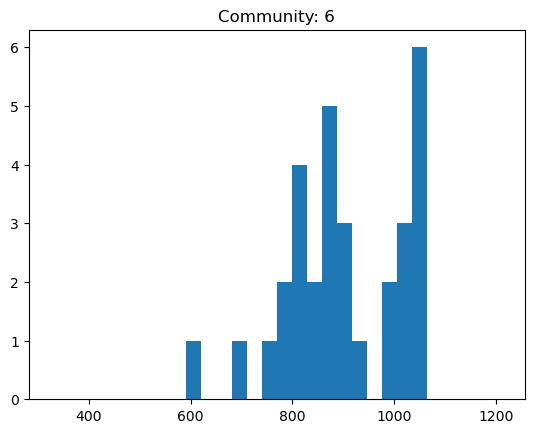

945.1297623709432
133.96611964315684


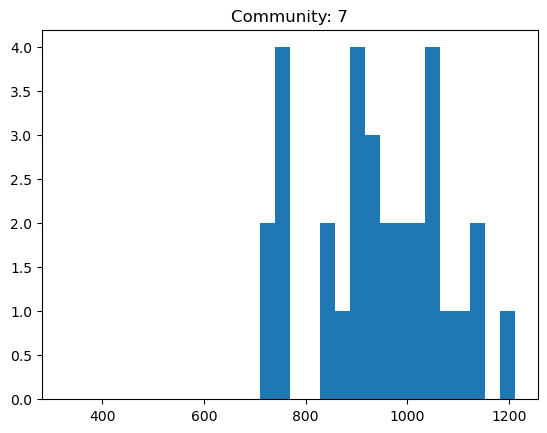

931.7950699397279
86.57184108771831


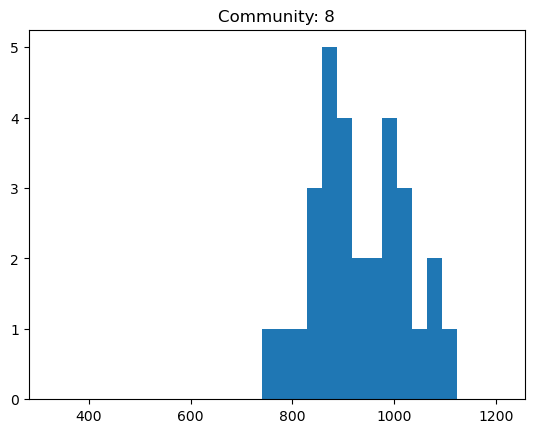

898.1858565843052
95.69882865530026


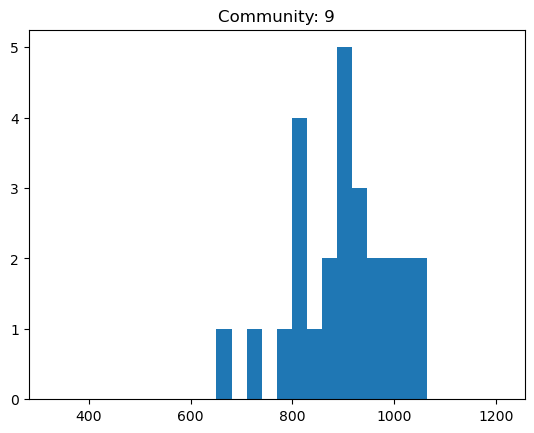

903.2002802408452
123.14391431004645


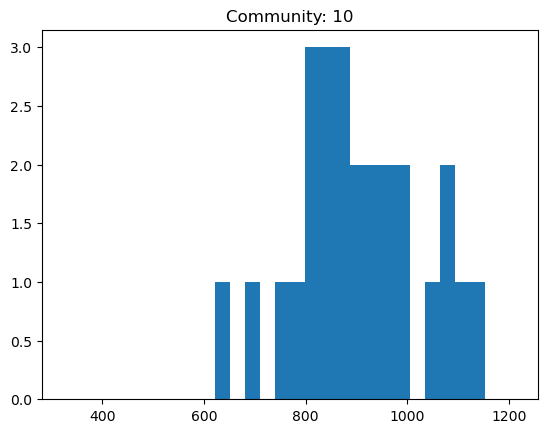

937.9836955784491
119.6494755612767


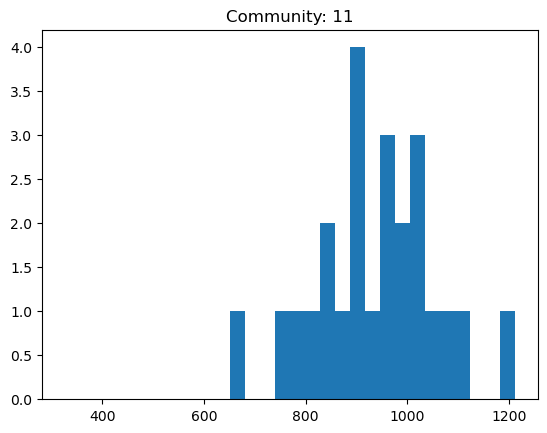

917.0221043629068
121.6813613748863


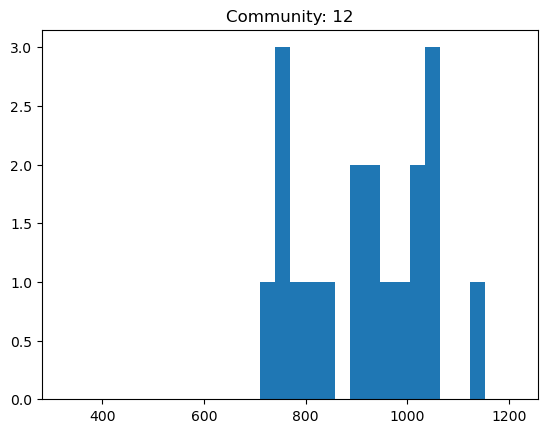

951.4299403648979
103.69673346775164


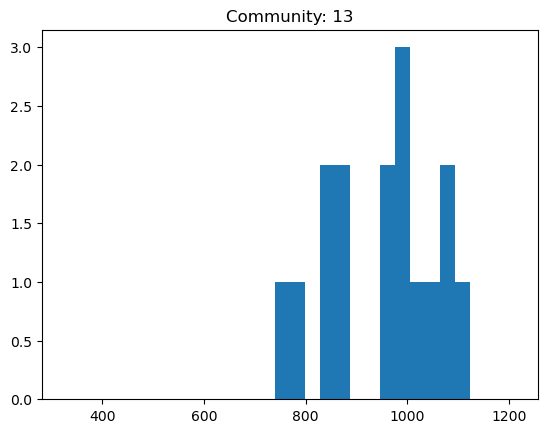

897.9171839922514
136.35287653463104


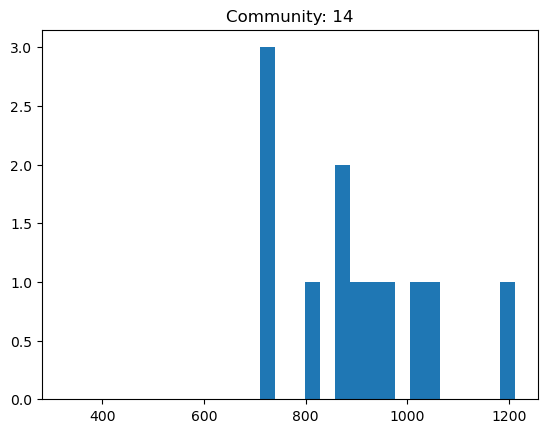

925.5528116082756
84.76359973158021


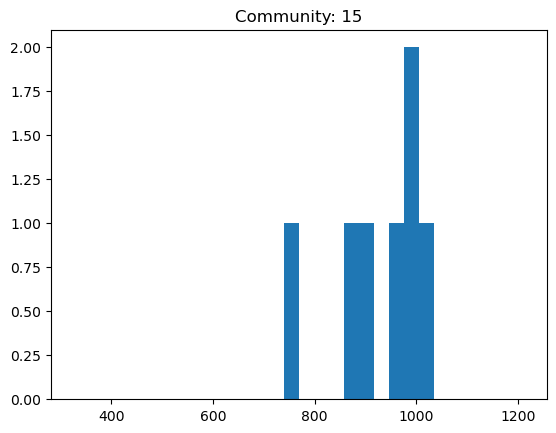

956.1662391296222
125.07628422277057


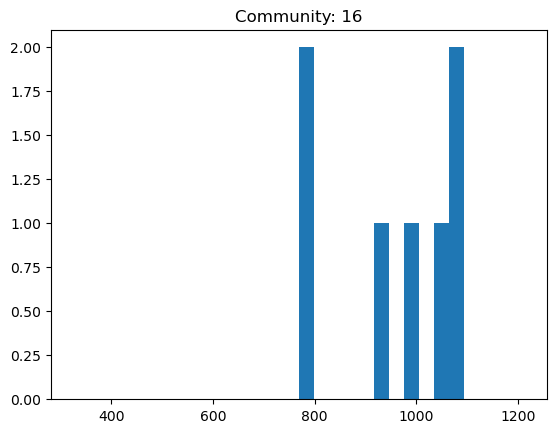

912.9430947132305
42.952520028892174


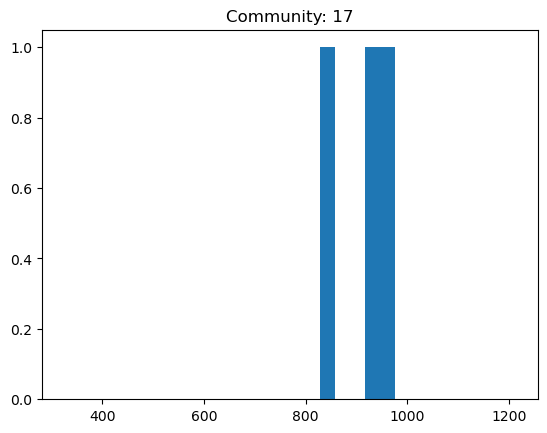

871.7688685636857
137.61483271697975


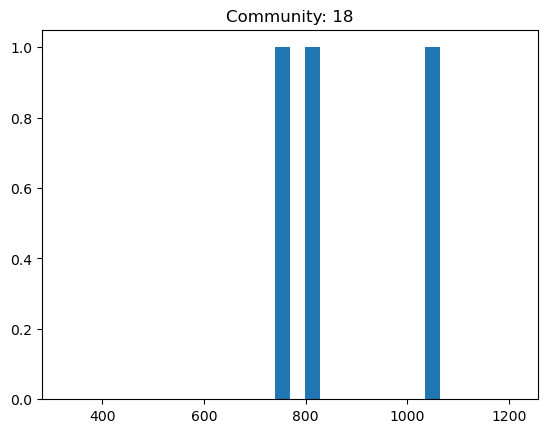

891.5021186440679
25.24788135593218


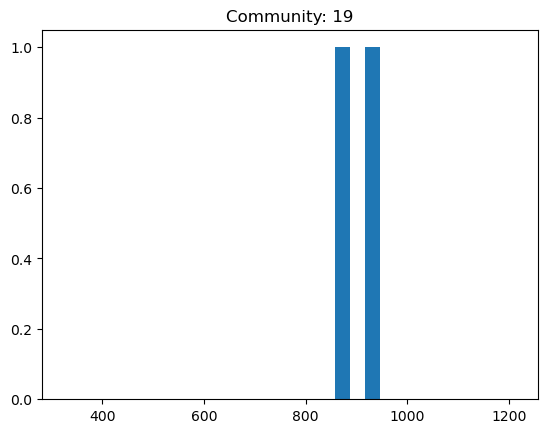

815.4300000000001
19.930000000000007


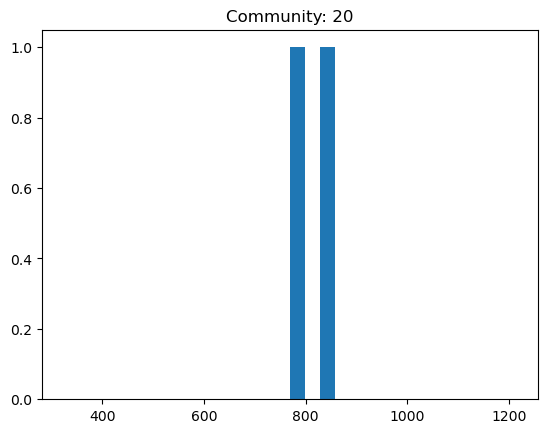

692.5906432748538
24.853801169590668


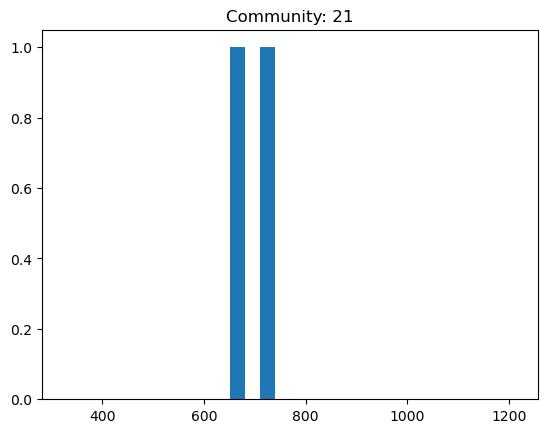

765.8333333333333
10.53333333333336


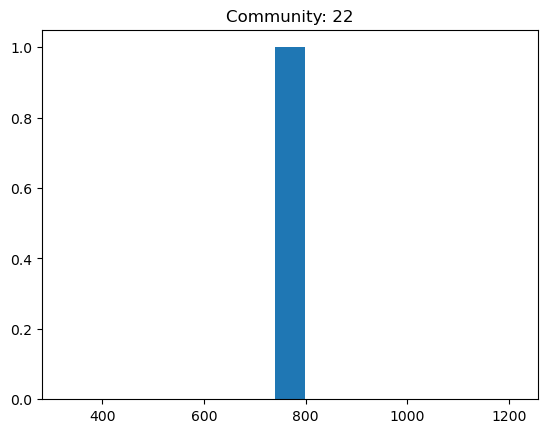

728.5282021151586
11.906580493536978


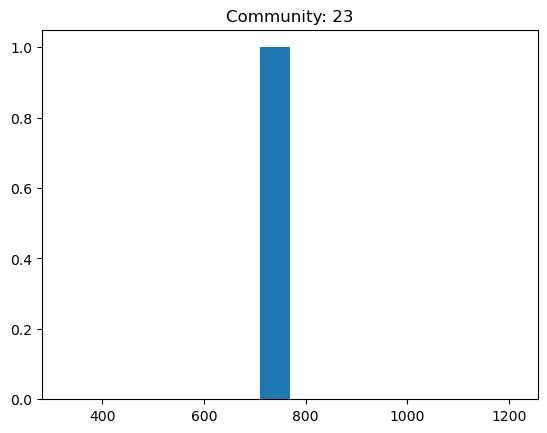

In [19]:
# Plot TOI per game of entire playerbase
player_data = players_df["average_TOI"].values
n , bins, patches = plt.hist(player_data, 30)
plt.xlabel("Average TOI")
plt.ylabel("Count")
plt.title("Overall Playerbase Average Ice Time Per Game")
plt.show()

# Plot corsi distribution of each community individually
node_data = dict(G.nodes(data="average_TOI", default=1))
i = 0
for community in greedy_communities:
    community_player_stats = []
    for player in community:
        community_player_stats.append(node_data[player])
    plt.hist(community_player_stats, bins)
    print(np.mean(community_player_stats))
    print(np.std(community_player_stats))
    title = "Community: " + str(i)
    plt.title(title)
    plt.show()
    i += 1

